In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5079893506139447940, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9202108990
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4129078203443274023
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import os
import numpy as np
np.random.seed(777)

import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
output_classes = 2
batch_size = 32 
img_height, img_width = 256, 256
epochs = 50

nb_train_samples = 3059
nb_validation_samples = 407
nb_test_samples = 459

In [5]:
train_dir = 'data/public/train/'
validation_dir = 'data/public/validation'
test_dir = 'data/public/test'

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [7]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/public/train/ 0
data/public/train/benign 504
data/public/train/malignant 2555
******************************
data/public/validation 0
data/public/validation\benign 66
data/public/validation\malignant 341
******************************
data/public/test 0
data/public/test\benign 72
data/public/test\malignant 387


In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3059 images belonging to 2 classes.
Found 407 images belonging to 2 classes.
Found 459 images belonging to 2 classes.


In [10]:
base_model = InceptionV3(input_shape=(256, 256, 3), weights='imagenet', include_top=False)

x = base_model.output
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# adam=Adam(lr=  1e-06, beta_1= 0.3, beta_2=0.8, epsilon=None, decay=0.0, amsgrad=params['amsgrad'])
sgd=SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)

model.compile(optimizer = "sgd", loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
95/95 [==============================] - 36s 376ms/step - loss: 0.4863 - acc: 0.8266 - val_loss: 0.4824 - val_acc: 0.8385
Epoch 2/50
95/95 [==============================] - 23s 241ms/step - loss: 0.4120 - acc: 0.8363 - val_loss: 0.4582 - val_acc: 0.8320
Epoch 3/50
95/95 [==============================] - 22s 231ms/step - loss: 0.2615 - acc: 0.8942 - val_loss: 0.7400 - val_acc: 0.6827
Epoch 4/50
95/95 [==============================] - 22s 232ms/step - loss: 0.0934 - acc: 0.9668 - val_loss: 1.3618 - val_acc: 0.5040
Epoch 5/50
95/95 [==============================] - 22s 232ms/step - loss: 0.0320 - acc: 0.9900 - val_loss: 1.3864 - val_acc: 0.6000
Epoch 6/50
95/95 [==============================] - 22s 232ms/step - loss: 0.0203 - acc: 0.9941 - val_loss: 1.5114 - val_acc: 0.5493
Epoch 7/50
95/95 [==============================] - 22s 232ms/step - loss: 0.0158 - acc: 0.9954 - val_loss: 1.5054 - val_acc: 0.5947
Epoch 8/50
95/95 [==============================] - 22s 232ms/step - 

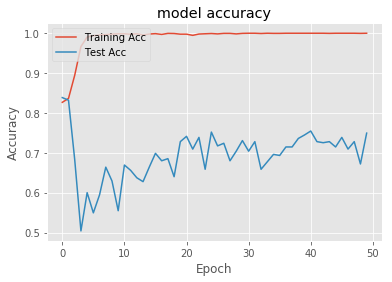

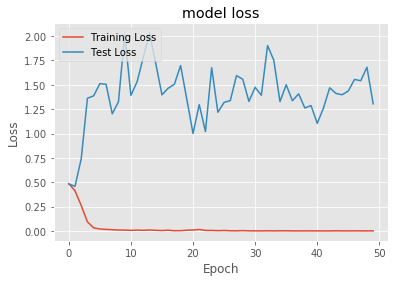

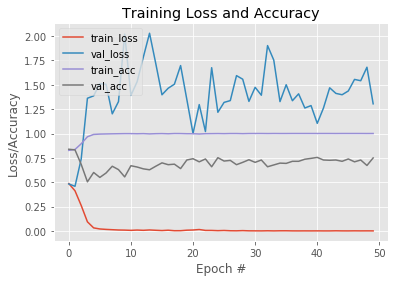

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [17]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  1.3981548072127126
Validation Accuracy:  0.7212276219407006


In [30]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

15/14 [===============================] - 1s 70ms/step
No of errors = 13/459


Confusion Matrix
[[ 70   2]
 [ 11 376]]


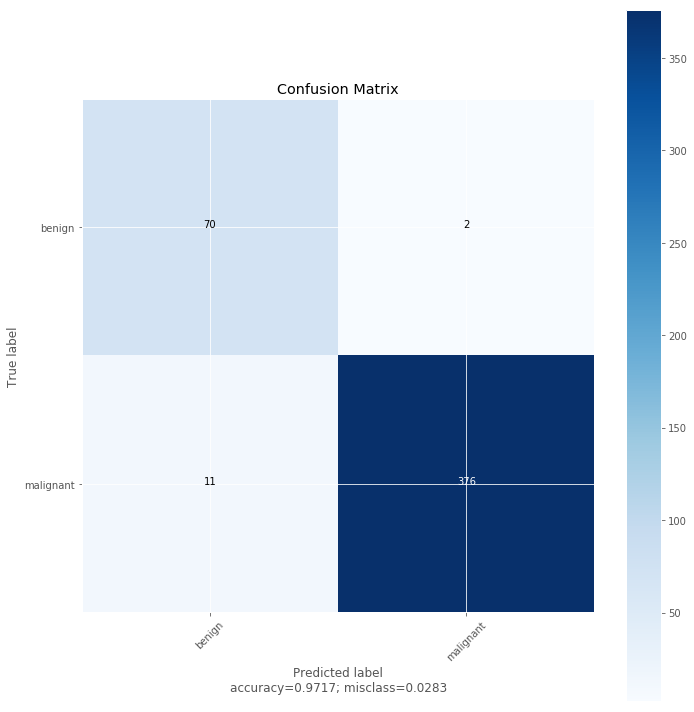

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
# fig.savefig('plots/1.Xception-CM.png') 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [32]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1])
y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
n_classes=2
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

KeyError: 'micro'

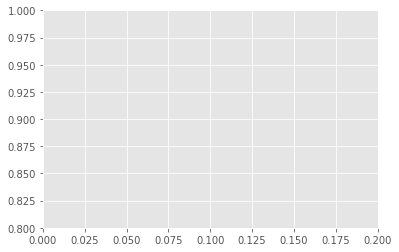

In [33]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-classs')
plt.legend(loc="lower right")
plt.savefig('plots/1.Xception-ROC.png') 
plt.show()

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[ 70   2]
 [ 11 376]]
              precision    recall  f1-score   support

      benign       0.86      0.97      0.92        72
   malignant       0.99      0.97      0.98       387

   micro avg       0.97      0.97      0.97       459
   macro avg       0.93      0.97      0.95       459
weighted avg       0.97      0.97      0.97       459



In [35]:
model.save('models/5.InceptionV3-Public-DataSet-Model.h5')
model.save_weights('models/5.InceptionV3-Public-DataSet-Weights.h5')

___

# L2 

In [64]:
from keras.regularizers import l2

base_model = InceptionV3(input_shape=(256, 256, 3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(2048, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
predictions = Dense(2, activation="softmax", kernel_regularizer=l2(0.001), bias_regularizer=l2(0.0001))(x)
model = Model(input = base_model.input, output = predictions)

In [65]:
sgd=SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)

model.compile(optimizer = "sgd", loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
95/95 [==============================] - 47s 497ms/step - loss: 16.5628 - acc: 0.5846 - val_loss: 18.9245 - val_acc: 0.5867
Epoch 2/50
95/95 [==============================] - 24s 252ms/step - loss: 15.7565 - acc: 0.6855 - val_loss: 15.2438 - val_acc: 0.8507
Epoch 3/50
95/95 [==============================] - 24s 253ms/step - loss: 15.1673 - acc: 0.7252 - val_loss: 14.8412 - val_acc: 0.8213
Epoch 4/50
95/95 [==============================] - 24s 253ms/step - loss: 14.6759 - acc: 0.7674 - val_loss: 14.3255 - val_acc: 0.8453
Epoch 5/50
95/95 [==============================] - 24s 252ms/step - loss: 14.2616 - acc: 0.7806 - val_loss: 13.8795 - val_acc: 0.8320
Epoch 6/50
95/95 [==============================] - 24s 253ms/step - loss: 13.8156 - acc: 0.7918 - val_loss: 13.4487 - val_acc: 0.8347
Epoch 7/50
95/95 [==============================] - 24s 253ms/step - loss: 13.2801 - acc: 0.8366 - val_loss: 13.0289 - val_acc: 0.8359
Epoch 8/50
95/95 [==============================] - 24s

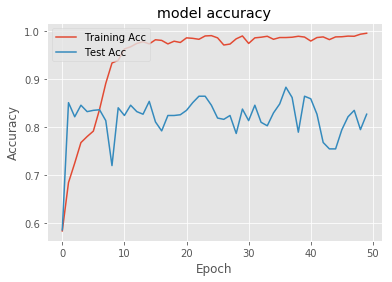

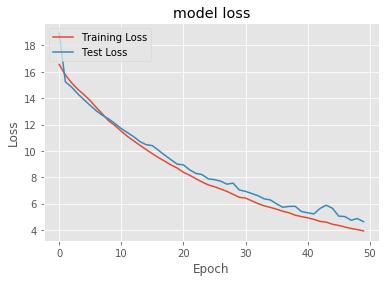

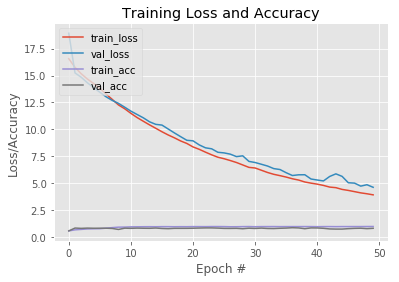

In [67]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [68]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  4.773317399232284
Validation Accuracy:  0.8184143220981979


In [86]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

15/14 [===============================] - 1s 74ms/step
No of errors = 24/459


Confusion Matrix
[[ 59  13]
 [ 11 376]]


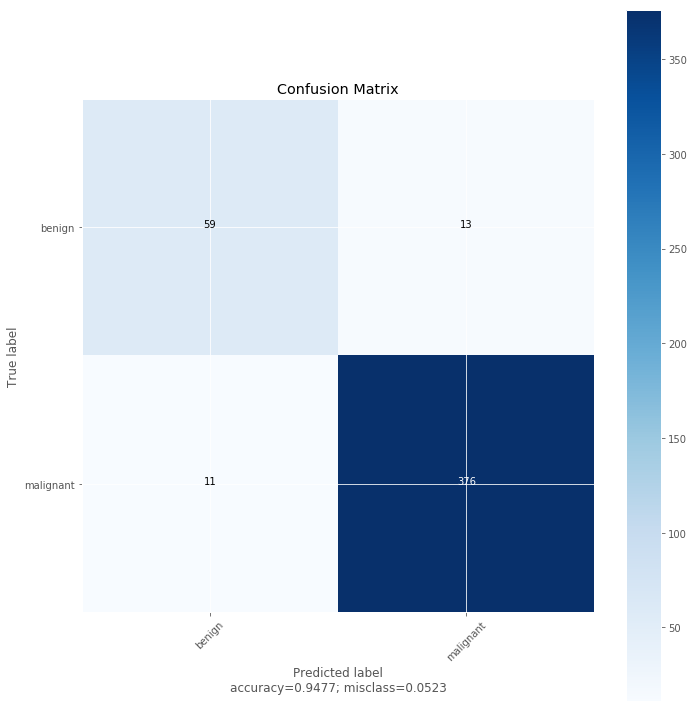

In [87]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
# fig.savefig('plots/1.Xception-CM.png') 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [88]:
model.save('models/5.InceptionV3-L2-Public-DataSet-Model.h5')
model.save_weights('models/5.InceptionV3-L2-Public-DataSet-Weights.h5')